In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
path = "gdrive/My Drive/Colab Notebooks/Tensorflow 2 and Keras/RNN/RSCCASN.csv"

In [ ]:
df = pd.read_csv(path, parse_dates=True, index_col="DATE")
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [ ]:
df.columns = ["Sales"]

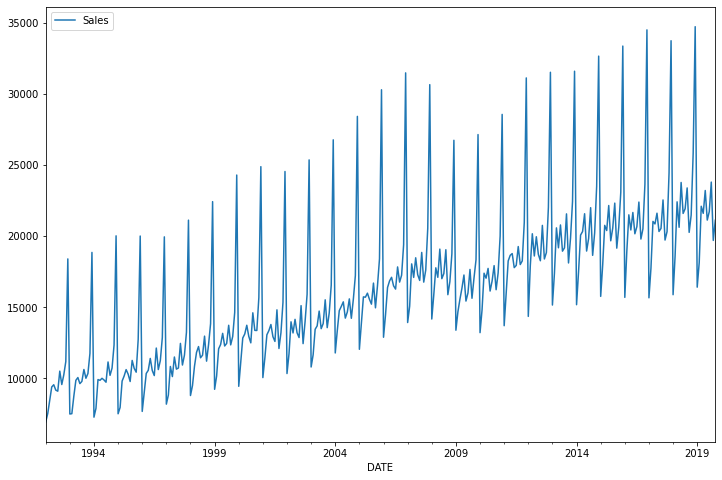

In [ ]:
df.plot(figsize=(12,8))

In [ ]:
len(df)

334

In [ ]:
test_size = 18 #one year and a half in months
test_ind = len(df) - test_size

In [ ]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [ ]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [ ]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
len(test)

18

In [ ]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [ ]:
X,y = generator[0]

In [ ]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [ ]:
y

array([[0.02047633]])

In [ ]:
len(X[0])

12

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.layers import Dense, LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(100, activation="relu", input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor="val_loss", patience=2)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [ ]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0274 - val_loss: 0.0260
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0197 - val_loss: 0.0044
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0115 - val_loss: 0.0044
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0050 - val_loss: 9.9771e-04
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 6/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0018 - val_loss: 0.0023


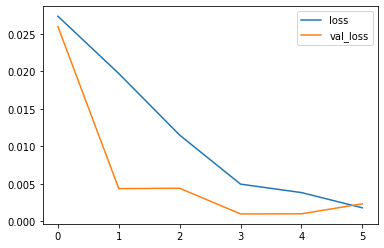

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test["Predictions"] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22358.011971
2018-06-01,21589,21236.847533
2018-07-01,21919,21524.362344
2018-08-01,23381,23394.232247
2018-09-01,20260,20932.962830
2018-10-01,21473,21576.090614
2018-11-01,25831,25776.341389
2018-12-01,34706,38307.984235
2019-01-01,16410,16971.096666


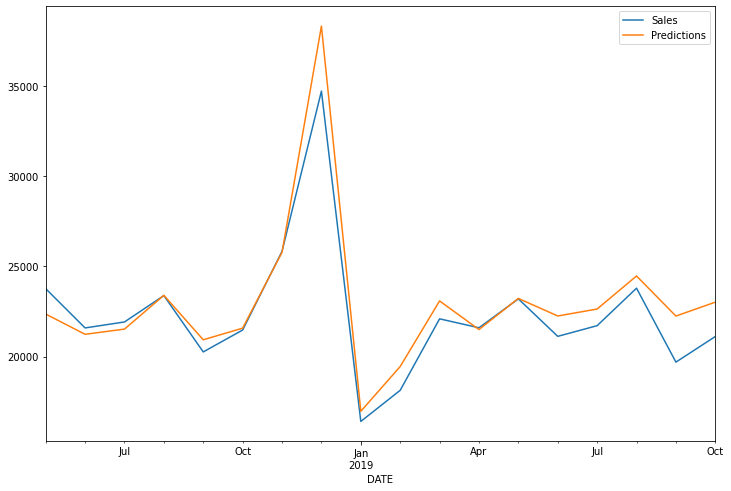

In [ ]:
test.plot(figsize=(12,8))

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100,activation="relu",input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.fit_generator(generator, epochs=5)

Epoch 1/5
322/322 [==============================] - 2s 6ms/step - loss: 0.0246
Epoch 2/5
322/322 [==============================] - 2s 5ms/step - loss: 0.0167
Epoch 3/5
322/322 [==============================] - 2s 5ms/step - loss: 0.0093
Epoch 4/5
322/322 [==============================] - 2s 5ms/step - loss: 0.0043
Epoch 5/5
322/322 [==============================] - 2s 5ms/step - loss: 0.0025


In [ ]:
forecast = []

periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(periods):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start="2019-11-01", periods=periods, freq="MS")

In [ ]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=["Forecast"])

In [ ]:
forecast_df

,Forecast
2019-11-01,26372.648096
2019-12-01,37356.169627
2020-01-01,17355.393480
2020-02-01,18890.769065
2020-03-01,22155.938773
2020-04-01,21850.453363
2020-05-01,23311.057892
2020-06-01,21607.559684
2020-07-01,22216.532495
2020-08-01,24131.327254


(576.0, 611.0)

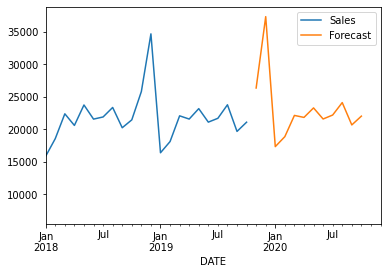

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim("2018-01-01", "2020-12-01")